# GP Regression on Protein Sequences: Bag of Amino Acids #

An example notebook for Tanimoto kernel-based GP regression on a dataset of protein sequences using a bag-of-amino acids representation of the protein sequence (analagous to the bag-of-SMILES model for molecules). The protein dataset consists of 151 sequences with a 'fitness' function (target label) of the melting point in degrees Celcius. The dataset is collated from values reported in references [1,2,3]. The sequences are each of length 290. For the Subsequence String Kernel (SSK) GP model see the 'GP Regression on Protein Sequences' notebook.

In [25]:
"""Imports"""

# Turn off Graphein warnings
import warnings
warnings.filterwarnings("ignore")

# To import from the gauche package
import sys
sys.path.append('..')

from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.models.fully_bayesian import MIN_INFERRED_NOISE_LEVEL
import gpytorch
from gpytorch.constraints import GreaterThan
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import torch

from gauche.dataloader.data_utils import transform_data
from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel

In [12]:
"""CPU/GPU"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tkwargs = {"dtype": torch.float, "device": device}
print(tkwargs)

{'dtype': torch.float32, 'device': device(type='cpu')}


## The Petase Dataset

The dataset consists of a set of petase protein sequences with amino acid chains of length 290. An example sequence is given below:

```
MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPPPTAASLEASAGPFTVRSFTVSRPSGYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQPSSRSSQQMAALRQVASLNGTSSSPIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAAPQAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCANSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCS
```

In [13]:
"""Auxiliary function to calculate bag of character representation of a protein string"""

def bag_of_amino_acids(sequences, max_ngram=5):
    """Compute the bag of amino acids representation of protein sequences.
    
    Args:
        sequences: List of Str representing the protein sequences
        max_ngram: Int specifying the maximum number of n-grams to consider
        
    Returns:
        NumPy array of counts for each n-gram present in the protein sequences
    """
    
    # extract bag of characters (boc) representation from strings
    cv = CountVectorizer(
        ngram_range=(1, max_ngram), analyzer="char", lowercase=False
    )
    return cv.fit_transform(sequences).toarray()


In [18]:
"""Load the petase dataset"""

df = pd.read_csv('../data/proteins/petase_151_mutants.csv')
sequences = df['sequence'].to_list()
X = bag_of_characters(sequences) # process to bag of amino acids
y = df['fitness'].to_numpy().reshape(-1, 1)
print(f'len(sequences) {len(sequences)} | len(targets) {len(y)}')

len(sequences) 151 | len(targets) 151


In [19]:
"""Regression experiments parameters, number of random splits and split size"""

n_trials = 20
test_set_size = 0.2

In [20]:
"""We define our GP model using the Tanimoto kernel."""

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [27]:
def evaluate_model(X, y):
    """
    Helper function for model evaluation
    
    X: Inputs
    y: Outputs
    """

    # initialise performance metric lists
    r2_list = []
    rmse_list = []
    mae_list = []
    
    # We pre-allocate array for plotting confidence-error curves

    _, _, _, y_test = train_test_split(X, y, test_size=test_set_size)  # To get test set size
    n_test = len(y_test)

    mae_confidence_list = np.zeros((n_trials, n_test))
    
    print('\nBeginning training loop...')

    for i in range(0, n_trials):
        
        print(f'Starting trial {i}')
                
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=i)

        #  We standardise the outputs but leave the inputs unchanged
        _, y_train, _, y_test, y_scaler = transform_data(X_train, y_train, X_test, y_test)

        # Convert numpy arrays to PyTorch tensors and flatten the label vectors
        X_train = torch.tensor(X_train.astype(np.float64))
        X_test = torch.tensor(X_test.astype(np.float64))
        y_train = torch.tensor(y_train).flatten()
        y_test = torch.tensor(y_test).flatten()

        # initialise GP likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(X_train, y_train, likelihood)

        # Find optimal model hyperparameters
        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        # Use the BoTorch utility for fitting GPs in order to use the LBFGS-B optimiser (recommended)
        fit_gpytorch_model(mll)

        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()

        # mean and variance GP prediction
        f_pred = model(X_test)

        y_pred = f_pred.mean
        y_var = f_pred.variance

        # Transform back to real data space to compute metrics and detach gradients. Must unsqueeze dimension
        # to make compatible with inverse_transform in scikit-learn version > 1
        y_pred = y_scaler.inverse_transform(y_pred.detach().unsqueeze(dim=1))
        y_test = y_scaler.inverse_transform(y_test.detach().unsqueeze(dim=1))
        
        # Compute scores for confidence curve plotting.

        ranked_confidence_list = np.argsort(y_var.detach(), axis=0).flatten()

        for k in range(len(y_test)):

            # Construct the MAE error for each level of confidence

            conf = ranked_confidence_list[0:k+1]
            mae = mean_absolute_error(y_test[conf], y_pred[conf])
            mae_confidence_list[i, k] = mae

        # Output Standardised RMSE and RMSE on Train Set
        y_train = y_train.detach()
        y_pred_train = model(X_train).mean.detach()
        train_rmse_stan = np.sqrt(mean_squared_error(y_train, y_pred_train))
        train_rmse = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train.unsqueeze(dim=1)), 
                                                y_scaler.inverse_transform(y_pred_train.unsqueeze(dim=1))))

        # Compute R^2, RMSE and MAE on Test set
        score = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        r2_list.append(score)
        rmse_list.append(rmse)
        mae_list.append(mae)
        
    r2_list = np.array(r2_list)
    rmse_list = np.array(rmse_list)
    mae_list = np.array(mae_list)
        
    print("\nmean R^2: {:.4f} +- {:.4f}".format(np.mean(r2_list), np.std(r2_list)/np.sqrt(len(r2_list))))
    print("mean RMSE: {:.4f} +- {:.4f}".format(np.mean(rmse_list), np.std(rmse_list)/np.sqrt(len(rmse_list))))
    print("mean MAE: {:.4f} +- {:.4f}\n".format(np.mean(mae_list), np.std(mae_list)/np.sqrt(len(mae_list)))) 
    
    # Plot confidence-error curves

    # 1e-14 instead of 0 to for numerical reasons!
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))  

    # We plot the Mean-absolute error confidence-error curves

    mae_mean = np.mean(mae_confidence_list, axis=0)
    mae_std = np.std(mae_confidence_list, axis=0)

    mae_mean = np.flip(mae_mean)
    mae_std = np.flip(mae_std)

    # 1 sigma errorbars

    lower = mae_mean - mae_std
    upper = mae_mean + mae_std
    
    warnings.filterwarnings("ignore")

    plt.plot(confidence_percentiles, mae_mean, label='mean')
    plt.fill_between(confidence_percentiles, lower, upper, alpha=0.2)
    plt.xlabel('Confidence Percentile')
    plt.ylabel('Melting Point (Celcius)')
    plt.ylim([0, np.max(upper) + 1])
    plt.xlim([0, 100 * ((len(y_test) - 1) / len(y_test))])
    plt.yticks(np.arange(0, np.max(upper) + 1, 5.0))
    plt.show()


Beginning training loop...
Starting trial 0
Starting trial 1
Starting trial 2
Starting trial 3
Starting trial 4
Starting trial 5
Starting trial 6
Starting trial 7
Starting trial 8
Starting trial 9
Starting trial 10
Starting trial 11
Starting trial 12
Starting trial 13
Starting trial 14
Starting trial 15
Starting trial 16
Starting trial 17
Starting trial 18
Starting trial 19

mean R^2: 0.8074 +- 0.0195
mean RMSE: 3.6824 +- 0.1306
mean MAE: 2.5381 +- 0.0956



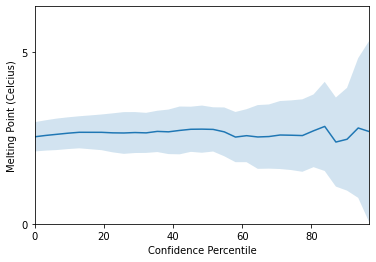

In [28]:
evaluate_model(X, y)

To summarise the results, the $R^2$ value obtained of $0.8$ is higher than for the SSK kernel! The bag of amino acids representation achieves a mean average error of 2.5 Celcius, not bad for such a simple model!

On the other hand the model's confidence estimates do not appear to be correlated with its prediction error, leaving room for thought.

## References

[1] Cui, Y., Chen, Y., Liu, X., Dong, S., Tian, Y.E., Qiao, Y., Mitra, R., Han, J., Li, C., Han, X. and Liu, W., 2021. [Computational redesign of a PETase for plastic biodegradation under ambient condition by the GRAPE strategy](https://pubs.acs.org/doi/abs/10.1021/acscatal.0c05126). ACS Catalysis, 11(3), pp.1340-1350.

[2] Liu, B., He, L., Wang, L., Li, T., Li, C., Liu, H., Luo, Y. and Bao, R., 2018. [Protein crystallography and site‐direct mutagenesis analysis of the poly (ethylene terephthalate) hydrolase PETase from Ideonella sakaiensis](https://chemistry-europe.onlinelibrary.wiley.com/doi/abs/10.1002/cbic.201800097). ChemBioChem, 19(14), pp.1471-1475.

[3] Joo, S., Cho, I.J., Seo, H., Son, H.F., Sagong, H.Y., Shin, T.J., Choi, S.Y., Lee, S.Y. and Kim, K.J., 2018. [Structural insight into molecular mechanism of poly (ethylene terephthalate) degradation](https://www.nature.com/articles/s41467-018-02881-1). Nature communications, 9(1), p.382.